In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

In [3]:
df = pd.read_csv('world_cup_penalty_data.csv', encoding='utf_8')
df.head()

,game_ID,year,host_country,stage,team,pre_penalties_score,won,winner_took_first_penalty,penalty_round,kick_in_round,penalty_scored,penalty_kicker
0,1,1982,Spain,Semi-finals,West Germany,3,True,False,1,2,True,Manfred Kaltz
1,2,1986,Mexico,Quarter-finals,France,1,True,False,1,2,True,Yannick Stopyra
2,3,1986,Mexico,Quarter-finals,West Germany,0,True,True,1,1,True,Klaus Allofs
3,4,1986,Mexico,Quarter-finals,Belgium,1,True,False,1,2,True,Nico Claesen
4,5,1990,Italy,Second round,Republic of Ireland,0,True,False,1,2,True,Kevin Sheedy


#  
# Investigating Loss Aversion Effects

The book "Thinking, Fast and Slow" introduced the concept of loss aversion to me. It's that we'll work harder to avoid a loss than for the same gain. 

In the book they explain loss aversion's effect in sport with golf. Professional players are worse at making putts for a birdie (gaining a stroke) than for par (avoiding losing a stroke). This is silly as only the total amount of strokes counts at the end of a game, not how many pars or birdies you get. However the players are affected by the reference point of each hole's amount of strokes for par regardless.

My thinking is that penalty shoot-outs have a similar reference point by being broken up into rounds. As most penalties are scored "par" for the team kicking first would be scoring, but "par" for the second depends on the first kick. If the first team score then they also need to score, but when the first team miss the second team's "par" is also missing and scoring becomes the "birdie" situation.

Shoot-outs have 5 rounds with one team winning a coin toss at the start to kick first each round. If loss aversion is happening I expect the team kicking second's accuracy to be affected by whether or not the first team scored their kick that round. I expect the second team to be worse at scoring after the first team misses as they're kicking for a gain that round and not trying as hard.

In [4]:
#split out only needed columns
#and get results of first and second kick for each round on same row
kickByRoundDf = df.pivot_table(index=['game_ID', 'penalty_round'], columns='kick_in_round', values='penalty_scored')
kickByRoundDf.head(15)

kick_in_round              1      2
game_ID penalty_round              
1       1               True   True
        2               True   True
        3               True  False
        4              False   True
        5               True   True
        6              False   True
2       1              False   True
        2               True   True
        3               True   True
        4               True  False
        5              False   True
3       1               True   True
        2               True  False
        3               True  False
        4               True   None

In [5]:
#remove multi-indexes so df is easier to iterate through
kickByRoundDf.reset_index(level=kickByRoundDf.index.names, inplace=True)

In [6]:
#get result from preceding 2nd kick on same row as first kicks
#NaNs put in for the first round of penalties as there won't have been a preceding round
prevKickResults = []
for i in range(len(kickByRoundDf)):
    if kickByRoundDf.iloc[i].penalty_round == 1:
        prevKickResults.append(np.nan)
    else:
        prevKickResults.append(kickByRoundDf.iloc[i-1][2]) #last [2] to select the column named 2, not a third element of something

kickByRoundDf['preceding_2nd_kick_result'] = prevKickResults
kickByRoundDf.head(15)

kick_in_round,game_ID,penalty_round,1,2,preceding_2nd_kick_result
0,1,1,True,True,NaN
1,1,2,True,True,True
2,1,3,True,False,True
3,1,4,False,True,False
4,1,5,True,True,True
5,1,6,False,True,True
6,2,1,False,True,NaN
7,2,2,True,True,True
8,2,3,True,True,True
9,2,4,True,False,True


In [7]:
#going to use df.mean so want to check it doesn't include na values in calculation
#should get same result both ways
print(kickByRoundDf[2].sum() / len(kickByRoundDf.dropna(subset=[2])))
print(kickByRoundDf[2].mean())

#both are the same so it's okay to use.

0.6992481203007519
0.699248120301


## Measuring Loss Aversion

In [8]:
print("Probabilities of:")
print("-----------------")

print("1st kick of round scoring: {0:.1f}% (n={1})".format(
    kickByRoundDf[1].mean()*100, len(kickByRoundDf[1].dropna())))
print("2nd kick of round scoring: {0:.1f}% (n={1})".format(
    kickByRoundDf[2].mean()*100, len(kickByRoundDf[2].dropna())))


print("-----------------------------------")
print("-1st kick of round scoring after...")
print("Previous round's second kick scored: {0:.1f}% (n={1})".format(
    kickByRoundDf[kickByRoundDf.preceding_2nd_kick_result==True][1].mean()*100,
    len(kickByRoundDf[kickByRoundDf.preceding_2nd_kick_result==True][1].dropna())))
print("Previous round's second kick missed: {0:.1f}% (n={1})".format(
    kickByRoundDf[kickByRoundDf.preceding_2nd_kick_result==False][1].mean()*100,
    len(kickByRoundDf[kickByRoundDf.preceding_2nd_kick_result==False][1].dropna())))


print("-----------------------------------")
print("-2nd kick of round scoring after...")
print("1st round scored: {0:.1f}% (n={1})".format(
    kickByRoundDf[kickByRoundDf[1]==True][2].mean()*100,
    len(kickByRoundDf[kickByRoundDf[1]==True][2].dropna())))
print("1st round missed: {0:.1f}% (n={1})".format(
    kickByRoundDf[kickByRoundDf[1]==False][2].mean()*100,
    len(kickByRoundDf[kickByRoundDf[1]==False][2].dropna())))

Probabilities of:
-----------------
1st kick of round scoring: 70.5% (n=146)
2nd kick of round scoring: 69.9% (n=133)
-----------------------------------
-1st kick of round scoring after...
Previous round's second kick scored: 69.9% (n=83)
Previous round's second kick missed: 69.7% (n=33)
-----------------------------------
-2nd kick of round scoring after...
1st round scored: 71.6% (n=95)
1st round missed: 65.8% (n=38)


**Oh wow!** There might be something here. The 1st kick of the round isn't affected by the preceding kick, but whether the first kick scored or not does seem to give different results for the second kick. Looks like the second kicks are more likely to miss after the first miss (scoring probability dropping to 65.8%) and score after the first scored (probability increasing to 71.6%). **But is it a significant effect?**

### Confidence in Significance of Result

It looks likes there's a noticeable loss aversion effect on the second kick, but better make sure it's statistically significant before I go round telling all my friends about it. There's a chance there's not enough samples to say the change isn't just random noise.

I'm choosing a significance level 0.10 as I'd like to be fairly sure there is an effect. If I'm wrong and falsely accuse the world's top footballers of not trying hard enough I'm not too bothered; I definitely won't be the first to do that :P

The null hypothesis is that the first kick of a round doesn't affect the outcome of the second, the alternate hypothesis is that it does.

In [52]:
#making contingency table in form:
#                        2nd_kick_of_round
#                        scored missed
#preceding_kick: scored    68    27
#                missed    25    13
continTable = np.array([[kickByRoundDf[kickByRoundDf[1]==True][2].sum(),
                         len(kickByRoundDf[(kickByRoundDf[1]==True) & (kickByRoundDf[2]==False)])
                        ],
                        [kickByRoundDf[kickByRoundDf[1]==False][2].sum(),
                         len(kickByRoundDf[(kickByRoundDf[1]==False) & (kickByRoundDf[2]==False)])
                        ]])

#using correction=False so Yate's correction isn't used as none of the 
#expected table values are below 5
chi, p, dof, mu = stats.chi2_contingency(continTable, correction=False)
print("chi: ", chi)
print("p:   ", p)
print("dof: ", dof)
print("expected values: \n", mu)

chi:  0.432607526882
p:    0.510712240525
dof:  1
expected values: 
 [[ 66.42857143  28.57142857]
 [ 26.57142857  11.42857143]]


### Conclusion: Fail to reject null hypothesis

**Awww...** A p-value of just 0.51 is way off the needed 0.1 to have confidence the measured difference isn't actually just random noise. I fail to reject the null hypothesis so the conclusion is that the outcome of the first kicks of a round aren't affecting the outcome of the second.

#  
# Other (non loss aversion related) Stats

In [14]:
print("Probaility of scoring a penalty:")
print("----------------------")
print("Overall: {0:.1f}% (n={1})".format(df.penalty_scored.mean()*100,
                                         len(df)))
print("For first kick in each round: {0:.1f}% (n={1})".format(
    df.penalty_scored[df.kick_in_round == 1].mean()*100,
    len(df.penalty_scored[df.kick_in_round == 1])))
print("For second kick in each round: {0:.1f}% (n={1})".format(
    df.penalty_scored[df.kick_in_round == 2].mean()*100,
    len(df.penalty_scored[df.kick_in_round == 2])))

Probaility of scoring a penalty:
----------------------
Overall: 70.3% (n=279)
For first kick in each round: 70.5% (n=146)
For second kick in each round: 69.9% (n=133)


###  Does going first help?

It seems that in general the team kicking first in a shoot out [win 60% of the time](https://en.wikipedia.org/wiki/Penalty_shoot-out_(association_football%29#Advantage_to_team_kicking_first?). In the World Cup however, over the 30 shootouts that have happened it's been 50-50 so far.

In [4]:
didWinnerKickFirstByGame = df.groupby('game_ID').mean()

print("Probaility of winning when:")
print("----------------------")
print("Kicking first: {0:.1f}% (n={1})".format(
    didWinnerKickFirstByGame.winner_took_first_penalty.mean()*100,
    len(didWinnerKickFirstByGame)))
print("Kicking second: {0:.1f}% (n={1})".format(
    (1-didWinnerKickFirstByGame.winner_took_first_penalty.mean())*100,
    len(didWinnerKickFirstByGame)))

Probaility of winning when:
----------------------
Kicking first: 50.0% (n=30)
Kicking second: 50.0% (n=30)


#### Effect of going first changes a lot over time

I've no ideas for explaining this, but it's very interesting that it swings form the first team almost never winning, to almost always winning, then back again.

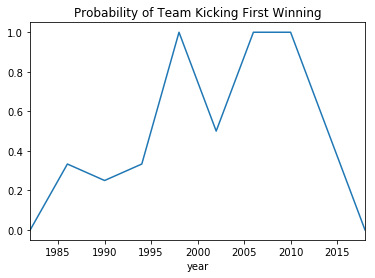

In [5]:
winningKickFirstByYear = didWinnerKickFirstByGame.groupby('year').winner_took_first_penalty.mean()
winningKickFirstByYear.plot()
plt.title('Probability of Team Kicking First Winning')
plt.show()

In [6]:
scoringProbByRound = df.pivot_table(index=['penalty_round'], 
                                     values='penalty_scored')
scoringProbByRound.rename(columns={'penalty_scored': 'Overall'}, inplace=True)
scoringProbByRound[['First_Kick_In_Round', 'Second_Kick_In_Round']] = df.pivot_table(index=['penalty_round'], 
                                                                                     columns='kick_in_round', 
                                                                                     values='penalty_scored')

scoringProbByRound['Overall_n'] = df.pivot_table(index=['penalty_round'], 
                                                  values='penalty_scored', 
                                                  aggfunc=lambda x: len(x))

scoringProbByRound[['First_Kick_In_Round_n', 'Second_Kick_In_Round_n']] = df.pivot_table(index=['penalty_round'], 
                                                                                          columns='kick_in_round', 
                                                                                          values='penalty_scored', 
                                                                                          aggfunc=lambda x: len(x))

scoringProbByRound

,Overall,First_Kick_In_Round,Second_Kick_In_Round,Overall_n,First_Kick_In_Round_n,Second_Kick_In_Round_n
penalty_round,,,,,,
1,0.750000,0.733333,0.766667,60,30,30
2,0.733333,0.733333,0.733333,60,30,30
3,0.733333,0.766667,0.700000,60,30,30
4,0.637931,0.666667,0.607143,58,30,28
5,0.648649,0.625000,0.692308,37,24,13
6,0.500000,0.500000,0.500000,4,2,2


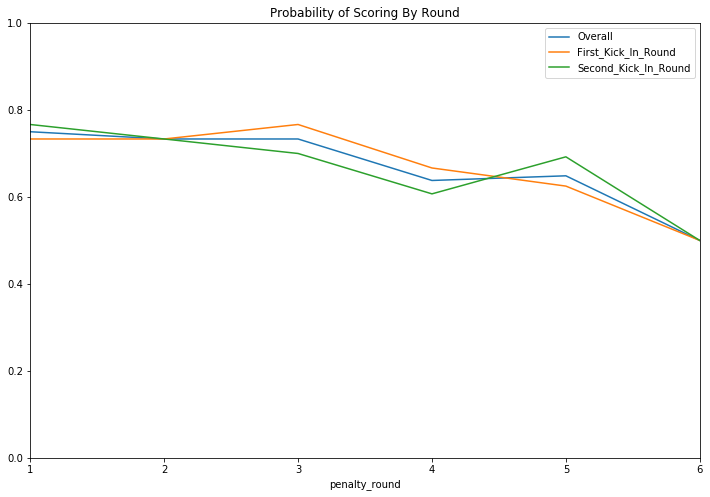

In [7]:
plt.rcParams['figure.figsize'] = (12, 8)
scoringProbByRound[['Overall', 'First_Kick_In_Round', 'Second_Kick_In_Round']].plot()
plt.ylim(0, 1)
plt.title('Probability of Scoring By Round')
plt.show()

**If any international footballers are reading...** try avoid taking the second kick of the fourth round if you can! This kick has the lowest scoring probability in the five normal rounds at 61%, nearly 10% lower than average.

Probability of scoring drops off as penalties go on. Likely as teams put the best penalty takers first as not all shoot outs make it to the later rounds.

The sample size of the 6th round, when it becomes sudden death penalties, is very low with only 4 kicks from two games so it may be wrong to draw conclusions from these. The drop to only a 50% chance of scoring does make sense to me though. The kicker is likely far from the first choice penalty taker and the pressure they're under must be immense.
